In [24]:
# Import libraries to use
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time, csv
from collections import defaultdict
from math import sqrt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM

from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [25]:
# Load only 'Close' column from CSV
def load_close(filePath):
    columns = defaultdict(list) # each value in each column is appended to a list

    with open(filePath) as f:
        reader = csv.DictReader(f)    # read rows into a dictionary format
        for row in reader:            # read a row as {column1: value1, column2: value2,...}
            for (k,v) in row.items(): # go over each column name and value 
                columns[k].append(v)  # append the value into the appropriate list based on column name k

    return columns['Close']

# Loading datasets and turn them into training and testing sets
def load_data_split_train_test(data, seq_len, normalize_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalize_window:
        result = normalize_windows(result)

    result = np.array(result)

    # Select 10% of the data for testing and 90% for training.
    # Select the last value of each example to be the target.
    # The other values are the sequence of inputs.
    # Shuffle the data in order to train in random order.
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    # Reshape the inputs from 1 dimenstion to 3 dimension
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

# Normalize function
# Normalize each value to reflect the percentage changes from starting point
def normalize_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

Training set has 4756 samples.
Testing set has 529 samples.
Coefficients: [0.02180116]
Variance score 0.5954321236390214
Mean Squared Error (MSE) 865.9815441006458
Root Mean Squared Error (RMSE) 29.42756435895852


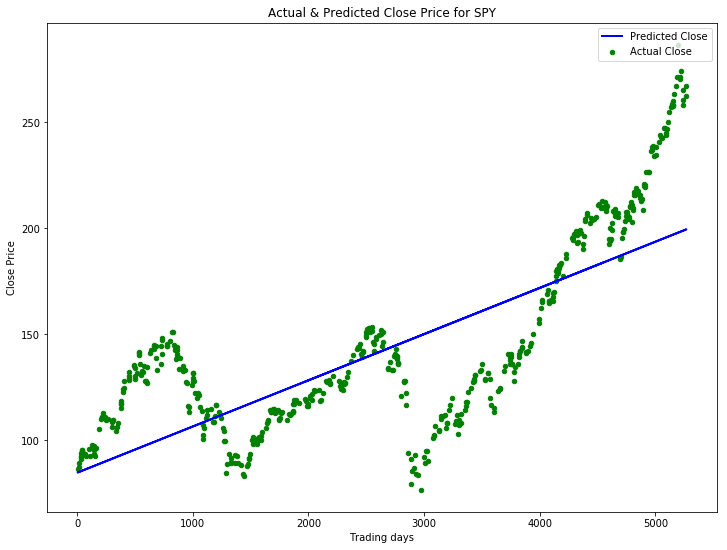

In [26]:
# Load data (Toyota Motor) and split it into training and testing
data = pd.read_csv('SPY2.csv')
dates = pd.DataFrame(np.arange(len(data)))
closes = data['Close']
X_train, X_test, y_train, y_test = train_test_split(dates, closes, test_size = 0.1, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

# Build Linear Regression model
regr = linear_model.LinearRegression()
regr.fit(X_train[:int(len(data)*0.9)], y_train[:int(len(data)*0.9)])

# Result (Accuracy score MSE and RMSE)
TM_MSE = np.mean((regr.predict(X_test) - y_test) ** 2)
TM_RMSE = sqrt(TM_MSE)



print ('Coefficients:', regr.coef_)
print ('Variance score', regr.score(X_test, y_test))
print ('Mean Squared Error (MSE)', TM_MSE)
print ('Root Mean Squared Error (RMSE)', TM_RMSE)

# Plot outputs
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(X_test, y_test, color='g', s=20, label='Actual Close')
plt.plot(X_test, regr.predict(X_test), color='b', linewidth=2, label='Predicted Close')

plt.xlabel('Trading days')
plt.ylabel('Close Price')

fig_size = plt.rcParams["figure.figsize"]
  
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

# Set title
ax.set_title('Actual & Predicted Close Price for SPY')
ax.legend(loc='upper right')

plt.show()

/Users/maccs3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/maccs3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 1), units=30)`
/Users/maccs3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
/Users/maccs3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4492 samples, validate on 237 samples
Epoch 1/1
4492/4492 [==============================] - 310s 69ms/step - loss: 2.5463e-04 - val_loss: 2.2598e-04


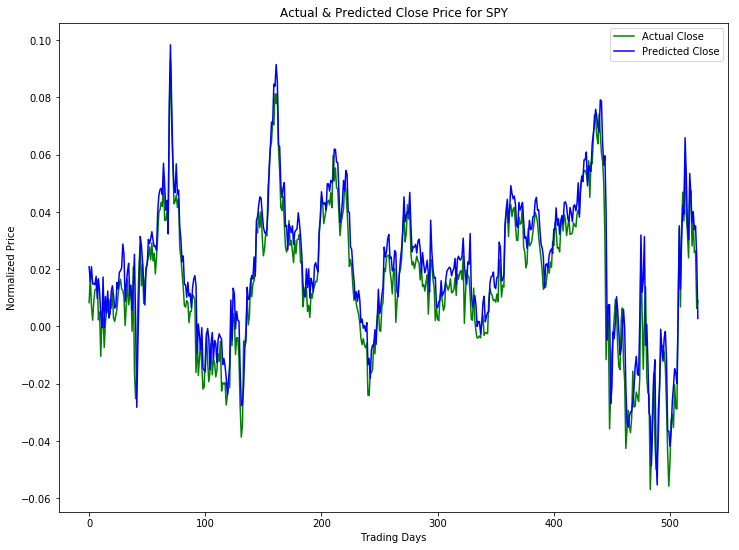

In [27]:
# LSTM Model parameters, I chose
batch_size = 1            # Batch size
nb_epoch = 1              # Epoch
seq_len = 30              # 30 sequence data
loss='mean_squared_error' # Since the metric is MSE/RMSE
optimizer = 'rmsprop'     # Recommended optimizer for RNN
activation = 'linear'     # Linear activation
input_dim = 1             # Input dimension
output_dim = 30           # Output dimension

# Get Close price and split the data into training and testing sets with helper functions
closes = load_close('SPY2.csv')
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(closes, seq_len, True)

# Initialize Sequential, which is a linear stack layer
model = Sequential()

# Add a LSTM layer with the input dimension is 1 and the output dimension is 50
# The output is not fed into next layer
model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

# Add Dense layer to aggregate the data from the prediction vector into a single value
model.add(Dense(
    output_dim=1))

# Add Linear Activation function
model.add(Activation(activation))

# Compile the model with MSE loss and RMSprop optimiser, since this is recommended for RNN
start = time.time()
model.compile(loss=loss, optimizer=optimizer)

# Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

# Predict
testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

# Result (MSE adn RMSE)
TM_MSE = score
TM_RMSE = math.sqrt(score)


# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Close')
plt.plot(testPredict, 'b', label='Predicted Close')

# Set title
ax.set_title('Actual & Predicted Close Price for SPY')
ax.legend(loc='upper right')

plt.show()

In [28]:
testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

TM_MSE = score
TM_RMSE = math.sqrt(score)
print ('Mean squared error (MSE)'), TM_MSE
print ('Root Mean squared error (RMSE)'), TM_RMSE

Mean squared error (MSE)
Root Mean squared error (RMSE)


(None, 0.008930454069661368)